<a href="https://colab.research.google.com/github/tulasiram58827/plot_top_losses_keras/blob/master/Plot_Top_Losses_Keras_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook authors:
- [tulasiram58827](http://github.com/tulasiram58827)
- [sayakpaul](http://github.com/sayakpaul)

## Initial setup

In [2]:
# Import TensorFlow and check its version
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
# Other imports
from tensorflow.keras import models, layers, datasets
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import math
import numpy as np

# Fix the random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Install wandb
!pip install wandb -q
!wandb login 

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: c21de9874bed09004d59e06aadc629e764218098
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


## Data collection and preparation

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0 # Scale the pixel values to [0,1] range

In [6]:
# Add a channel dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]
train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [0]:
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.transform(test_labels)
train_labels = train_labels.astype('float')
test_labels = test_labels.astype('float')

## Model definition

In [0]:
# Define the model
def get_training_model(smoothing_factor=0):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    model.add(layers.Softmax())

    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE, label_smoothing=smoothing_factor),
              metrics=['accuracy'])
    
    return model

In [9]:
model = get_training_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

## Model training sanity check

In [10]:
model = get_training_model()
history = model.fit(train_images, train_labels, epochs=1, 
                    validation_data=(test_images, test_labels))

1875/1875 [==============================] - 7s 3ms/step - loss: 1.6226 - accuracy: 0.8403 - val_loss: 1.5722 - val_accuracy: 0.8889


In [11]:
test_pred = model.predict(test_images)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
loss_values = loss(test_labels,test_pred).numpy()
print(loss_values, len(loss_values))

[1.4611502 1.4611502 1.4611505 ... 1.46115   2.461001  1.461168 ] 10000


## Function to plot the images from the test set that cause the top losses

In [0]:
def plot_top_losses(actual, pred, k=9, figsize=(10,10)):
  loss_values = loss(actual,pred).numpy()
  top_k = loss_values.argsort()[-k:][::-1]
  cols = math.ceil(math.sqrt(k))
  rows = math.ceil(k/cols)
  fig,axes = plt.subplots(rows, cols, figsize=figsize)
  fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14)
  i =0
  for index in top_k:
    image = test_images[index]
    actual = np.argmax(test_labels[index])
    loss_value = loss_values[index]
    predicted = np.argmax(pred[index])
    prob = pred[index][predicted]
    title = f'{predicted}/{actual}/{loss_value:.2f}/{prob:.2f}'
    ax = axes.flat[i]
    i+=1
    image = np.squeeze(image,axis=2)
    ax.imshow(image)
    ax.set_title(title)

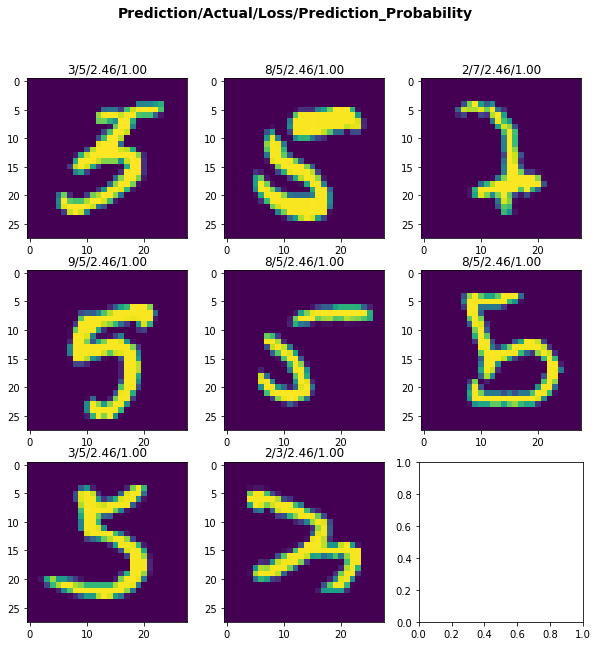

In [13]:
plot_top_losses(test_labels,test_pred,k=8)

## Creating a callback that implements the above for train dataset

In [14]:
import wandb

wandb.init(project="plot-top-losses", id="No_smoothing")

W&B Run: https://app.wandb.ai/tulasi1729/plot-top-losses/runs/No_smoothing

In [0]:
class PlotTopLosses(tf.keras.callbacks.Callback):
    def __init__(self, k=3, frequency=2,smoothing_factor=0):
        self.k = k
        self.freq = frequency
        self.factor = smoothing_factor
        super(PlotTopLosses, self).__init__()
    def on_epoch_begin(self, epoch, logs=None):
        self.top_loss = defaultdict(list)
    def on_epoch_end(self, epoch, logs=None):
      if epoch%self.freq == 0:
          train_pred = self.model.predict(train_images)
          loss_values = self.model.loss(train_labels,train_pred).numpy()
          top_k = loss_values.argsort()[-self.k:][::-1]
          for index in top_k:
              actual_class = train_labels[index]
              loss_value = loss_values[index]
              predicted_class = np.argmax(train_pred[index])
              prob = train_pred[index][predicted_class]
              self.top_loss[epoch,index].append([predicted_class,actual_class,loss_value,prob])
          self.plot_losses(epoch)

    def plot_losses(self, epoch, figsize=(10, 10)):
        cols = math.ceil(math.sqrt(self.k))
        rows = math.ceil(self.k/cols)
        fig,axes = plt.subplots(rows, cols, figsize=figsize)
        fig.suptitle('Prediction/Actual/Loss/Prediction_Probability/epoch', weight='bold', size=14)
        
        i = 0

        for ((epoch,index), plot_stuff) in self.top_loss.items():
            # Unpack the values
            image = train_images[index]
            actual_label = np.argmax(train_labels[index])
            loss_value = plot_stuff[0][2]
            predicted = plot_stuff[0][0]
            prob = plot_stuff[0][3]

            # Prepare the plot
            title = f'{predicted}/{actual_label}/{loss_value:.2f}/{prob:.2f}/{epoch}'
            ax = axes.flat[i]
            i+=1
            image = np.squeeze(image,axis=2)
            ax.imshow(image)
            ax.set_title(title)

        wandb.log({"top_losses": fig})
        wandb.log({"smoothing_factor": self.factor})

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.6416 - accuracy: 0.8207 - val_loss: 1.5762 - val_accuracy: 0.8840
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.5061 - accuracy: 0.9548 - val_loss: 1.4778 - val_accuracy: 0.9837
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.4784 - accuracy: 0.9830 - val_loss: 1.4757 - val_accuracy: 0.9858
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.4762 - accuracy: 0.9851 - val_loss: 1.4733 - val_accuracy: 0.9879
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.4758 - accuracy: 0.9854 - val_loss: 1.4746 - val_accuracy: 0.9865
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.4737 - accuracy: 0.9874 - val_loss: 1.4708 - val_accuracy: 0.9908
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.4744 - accuracy: 0.9868 - val_loss: 1.4773 - val_accuracy:

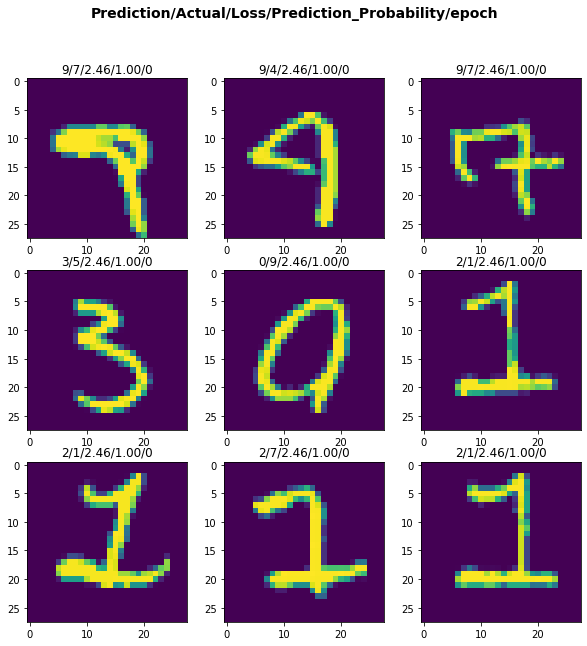

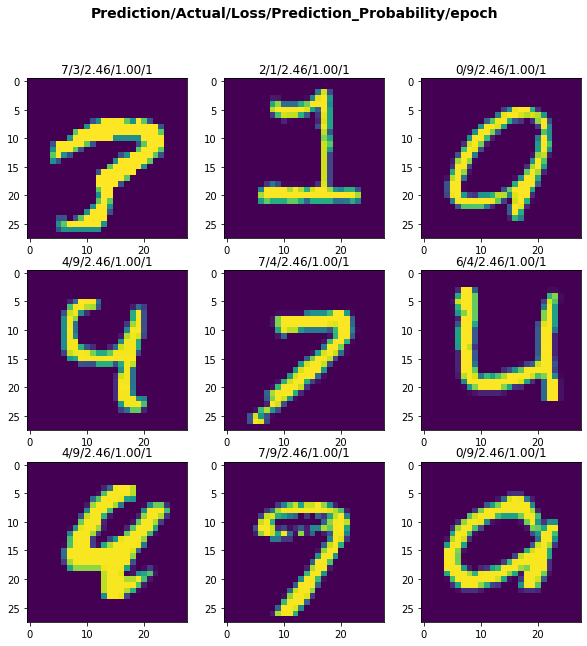

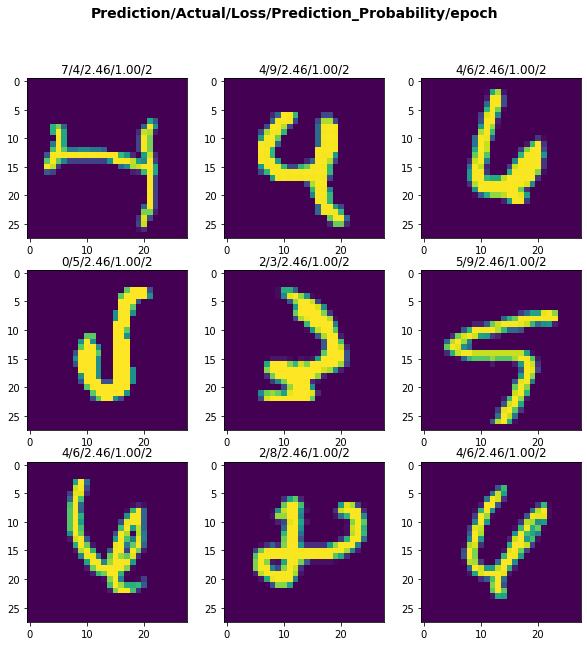

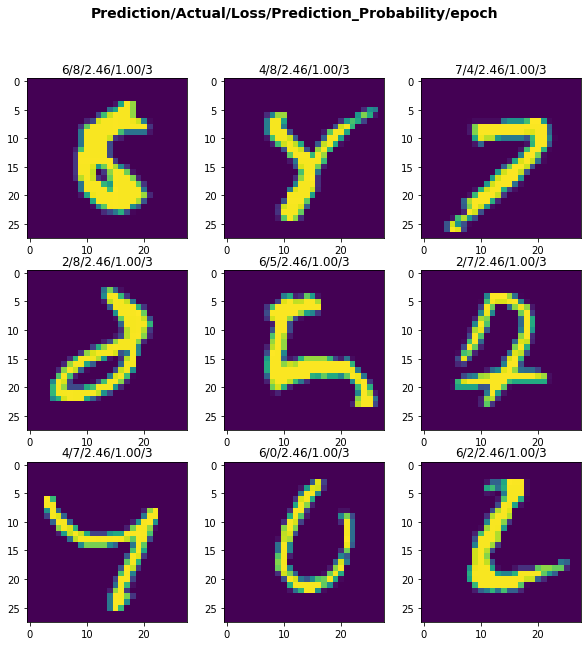

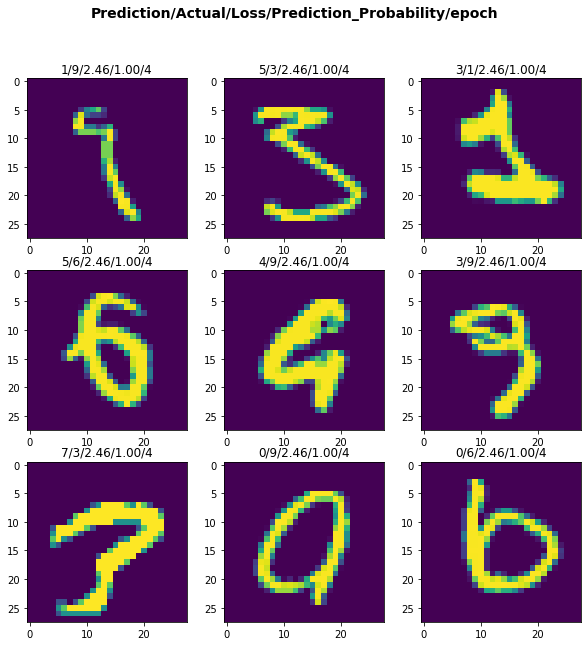

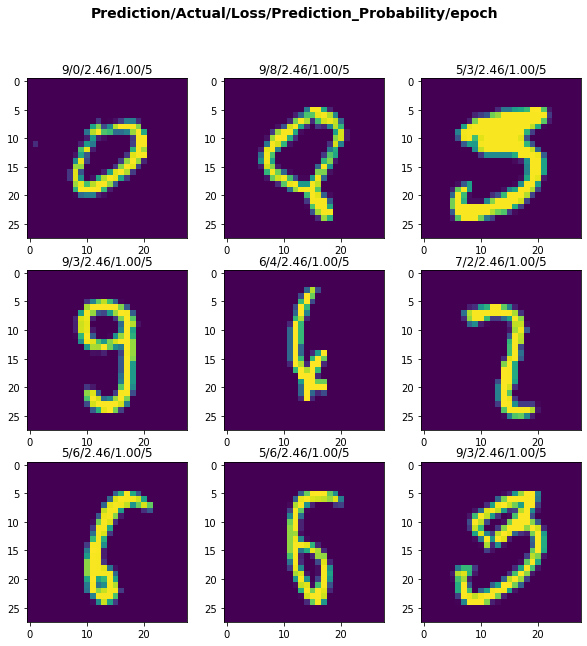

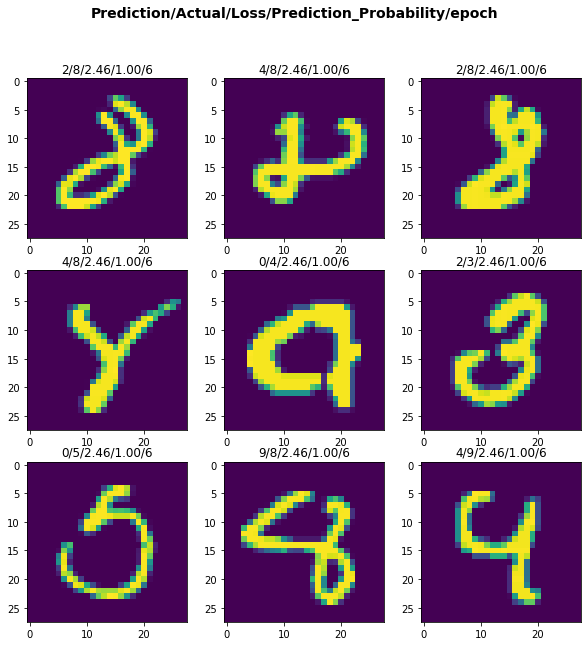

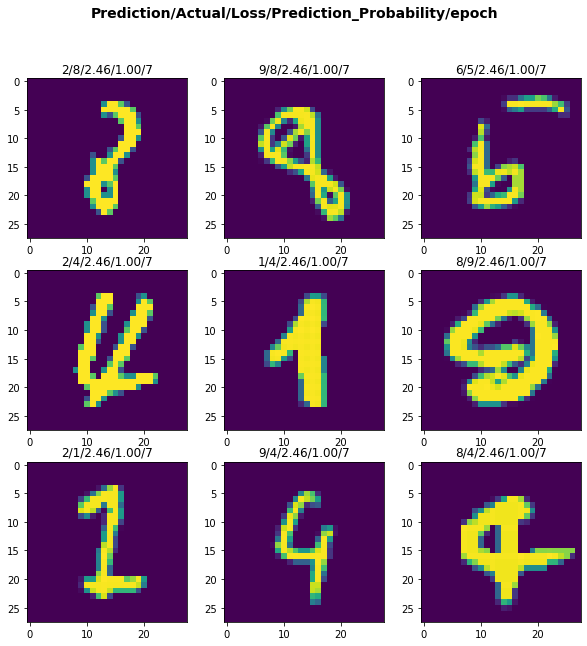

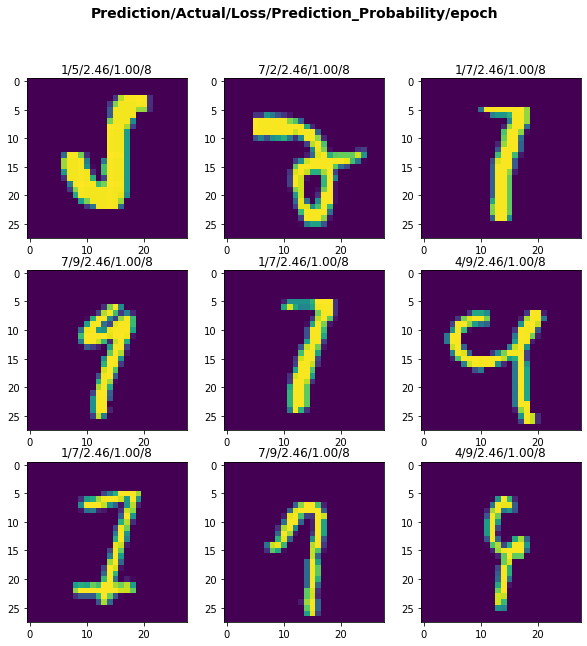

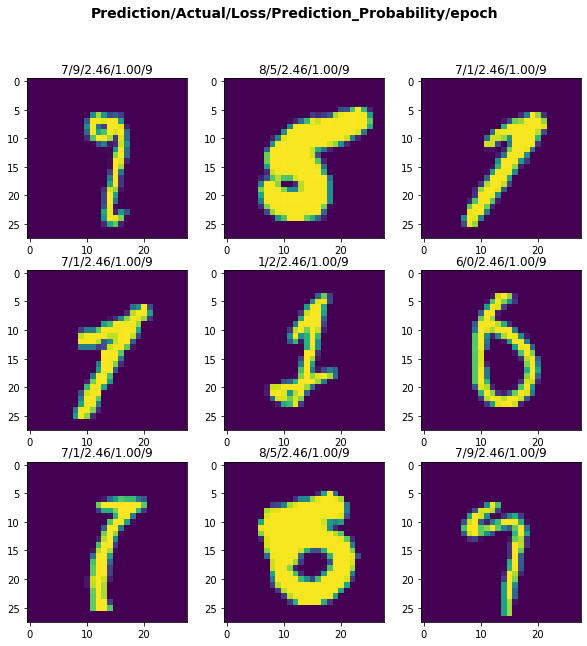

In [16]:
model = get_training_model()
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels),
                    callbacks=[PlotTopLosses(k=9, frequency=1),
                              wandb.keras.WandbCallback()])

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.6621 - accuracy: 0.8784 - val_loss: 1.5751 - val_accuracy: 0.9746
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.5729 - accuracy: 0.9761 - val_loss: 1.5720 - val_accuracy: 0.9770
Epoch 3/10
1875/1875 [==============================] - 8s 5ms/step - loss: 1.5684 - accuracy: 0.9809 - val_loss: 1.5653 - val_accuracy: 0.9847
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.5660 - accuracy: 0.9835 - val_loss: 1.5669 - val_accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 8s 5ms/step - loss: 1.5649 - accuracy: 0.9848 - val_loss: 1.5673 - val_accuracy: 0.9821
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.5636 - accuracy: 0.9862 - val_loss: 1.5647 - val_accuracy: 0.9850
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.5642 - accuracy: 0.9854 - val_loss: 1.5670 - val_accuracy:

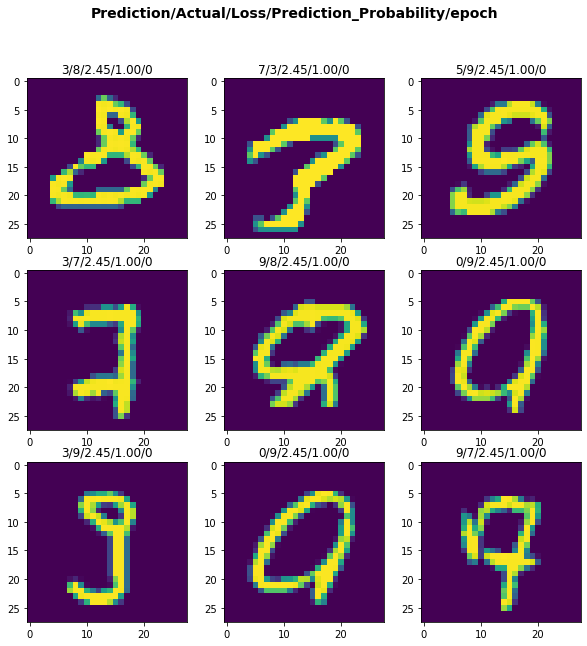

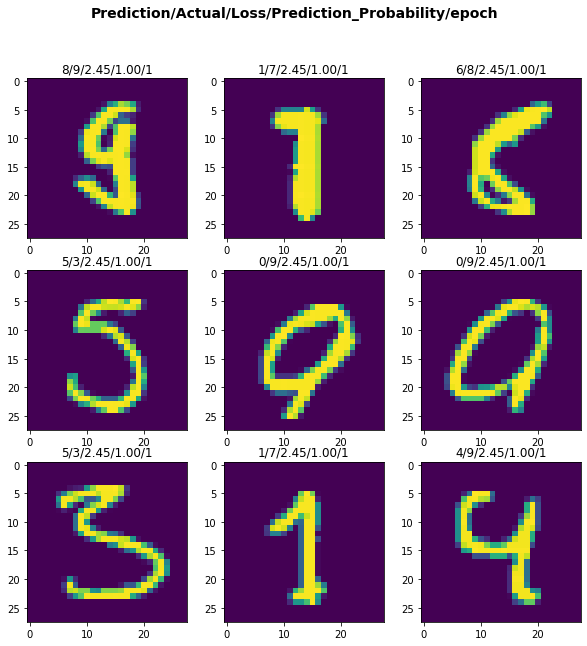

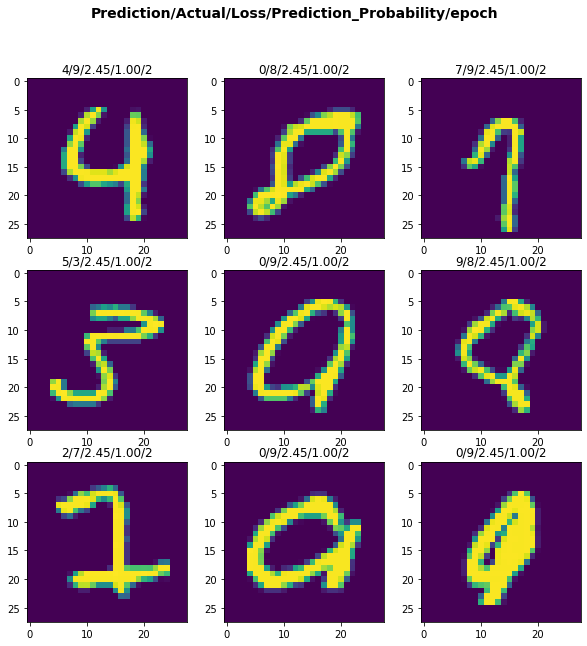

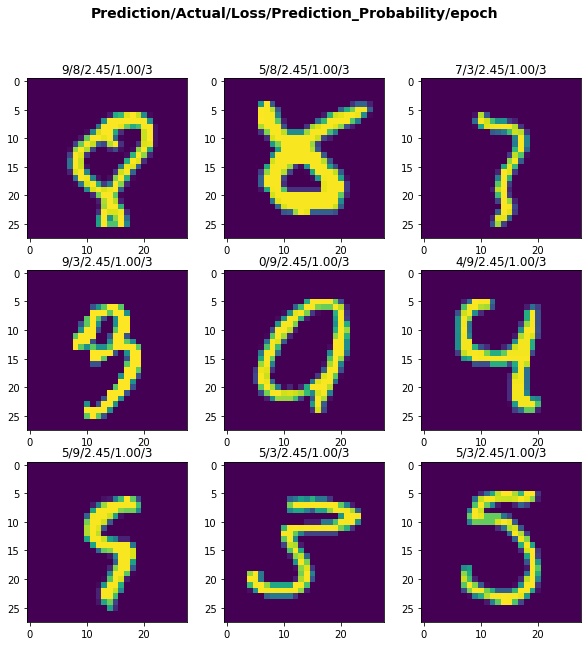

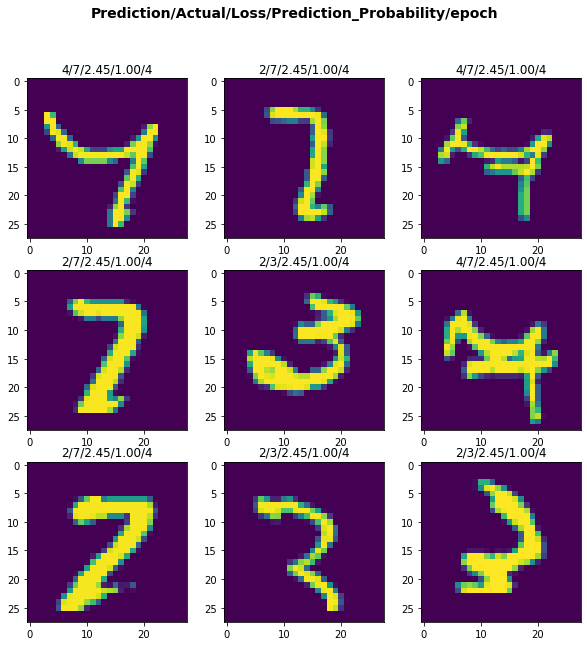

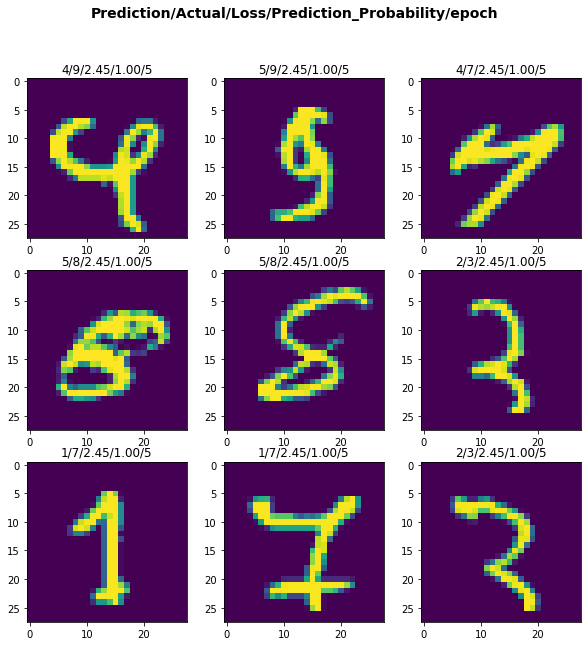

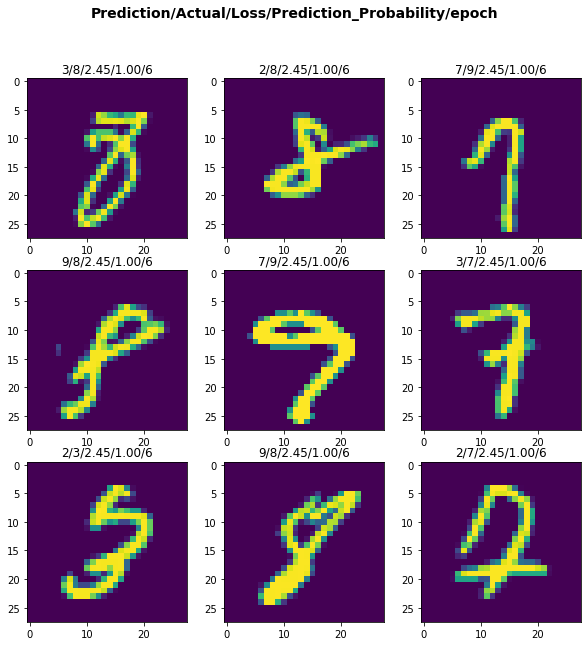

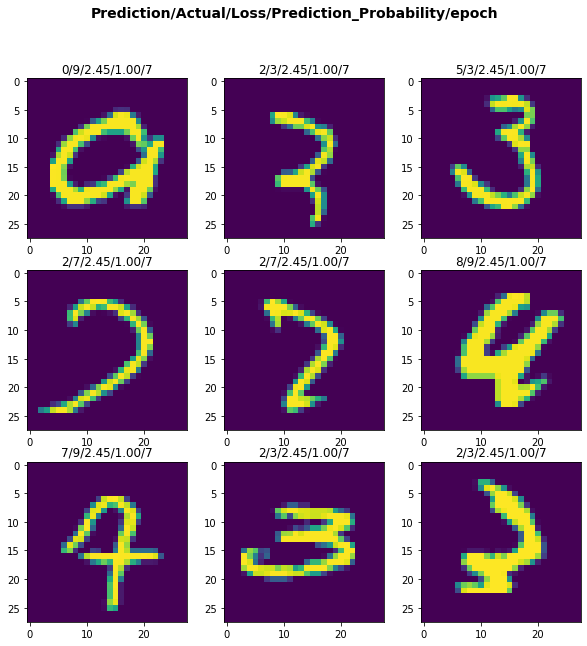

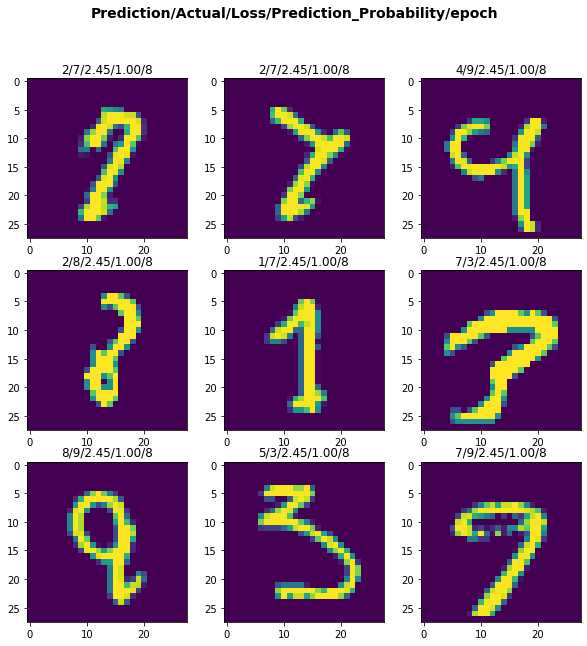

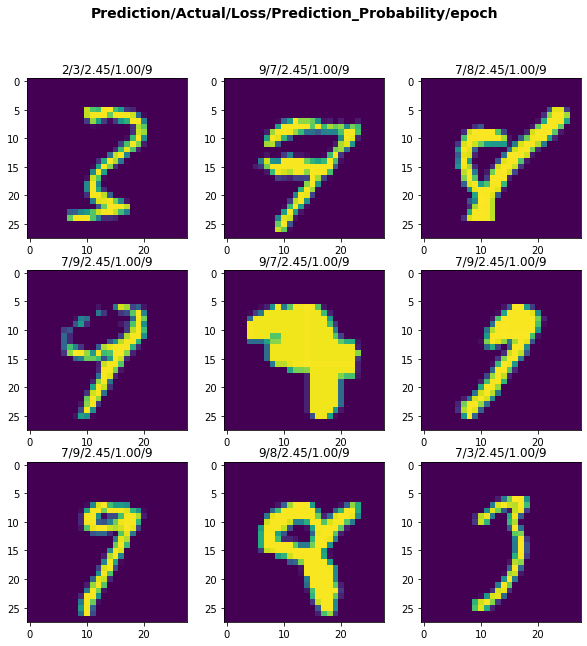

In [17]:
wandb.init(project="plot-top-losses", id="Smoothing Factor-0.1")
model = get_training_model(0.1)
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels),
                    callbacks=[PlotTopLosses(k=9, frequency=1,smoothing_factor=0.1),
                               wandb.keras.WandbCallback()])

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.7638 - accuracy: 0.8473 - val_loss: 1.7450 - val_accuracy: 0.8707
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.6670 - accuracy: 0.9683 - val_loss: 1.6573 - val_accuracy: 0.9807
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.6571 - accuracy: 0.9801 - val_loss: 1.6580 - val_accuracy: 0.9786
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.6549 - accuracy: 0.9828 - val_loss: 1.6520 - val_accuracy: 0.9865
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.6530 - accuracy: 0.9852 - val_loss: 1.6582 - val_accuracy: 0.9781
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.6531 - accuracy: 0.9851 - val_loss: 1.6516 - val_accuracy: 0.9867
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.6513 - accuracy: 0.9873 - val_loss: 1.6523 - val_accuracy:

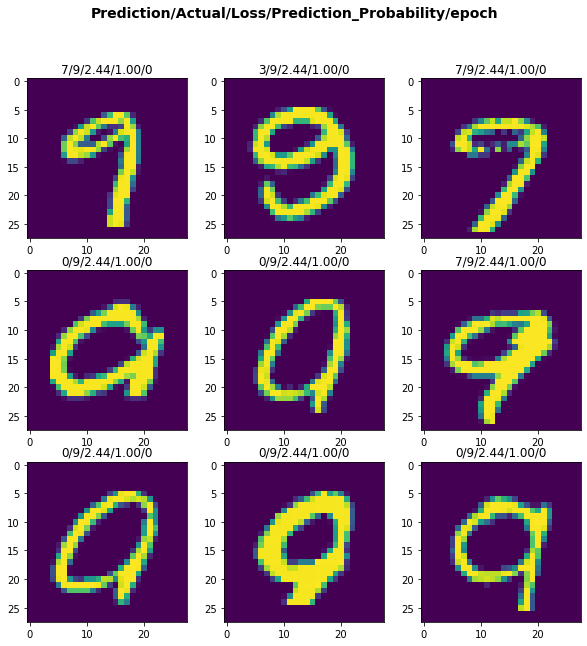

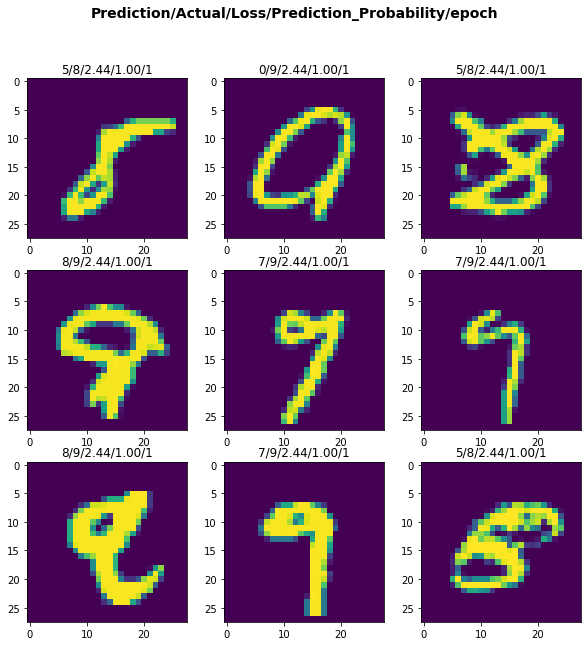

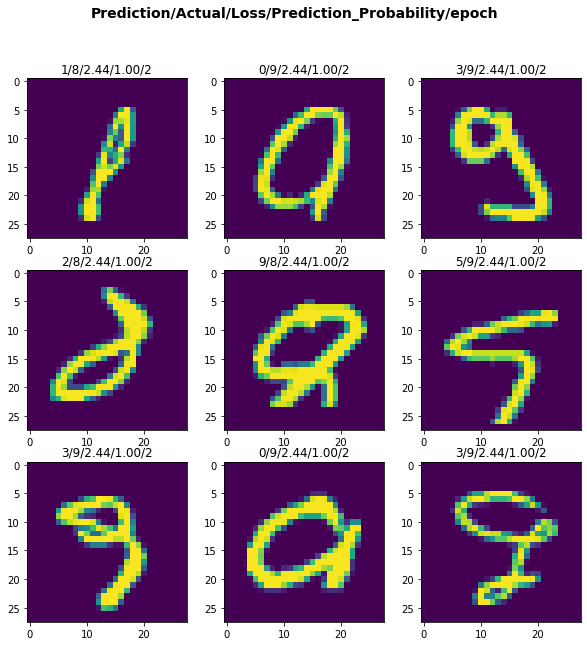

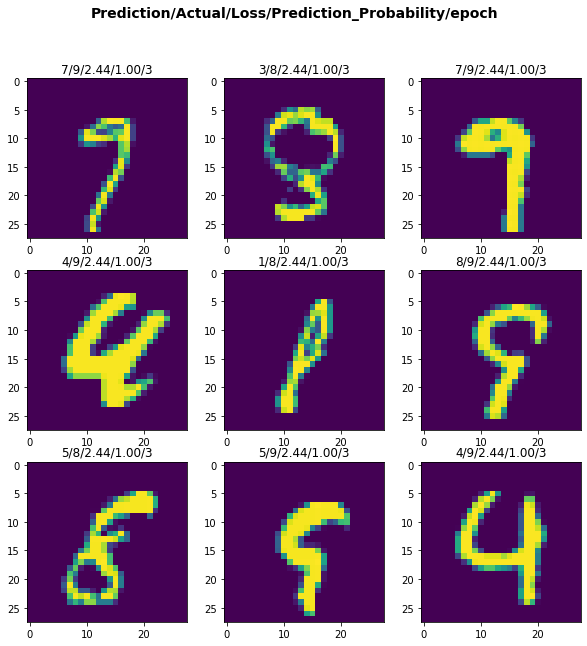

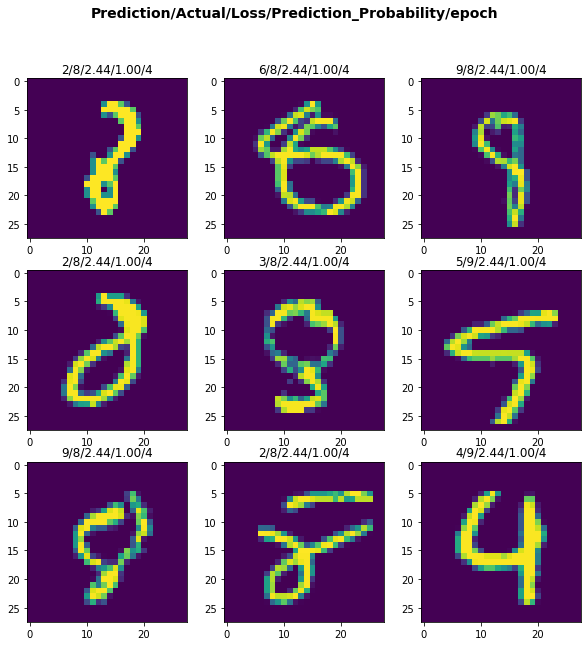

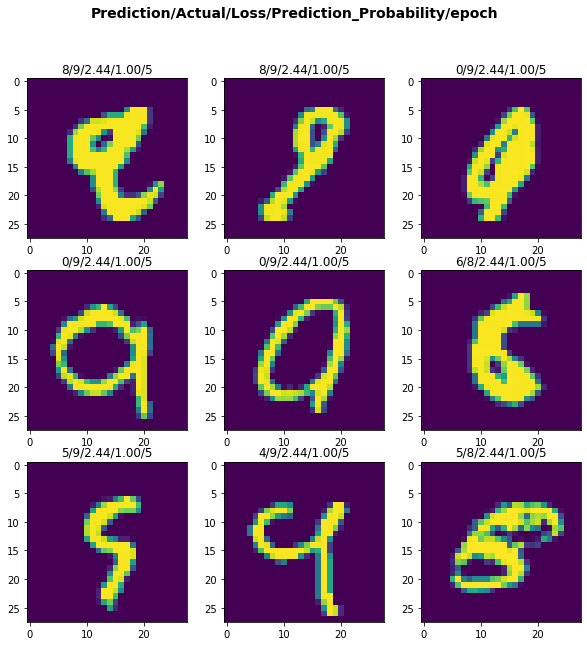

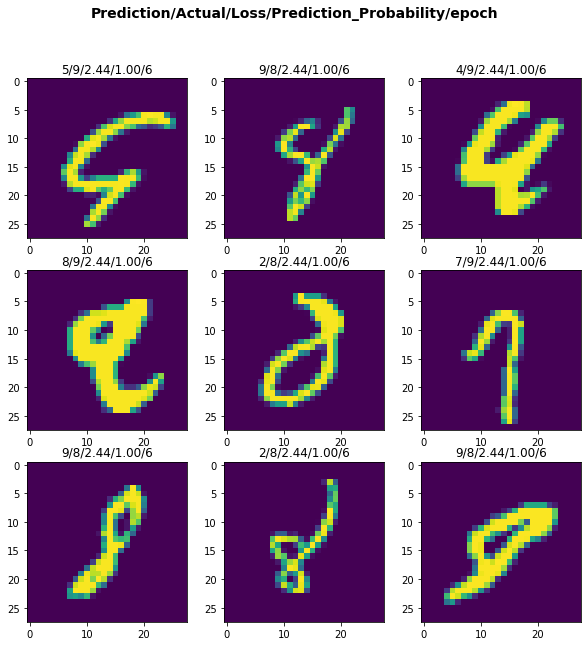

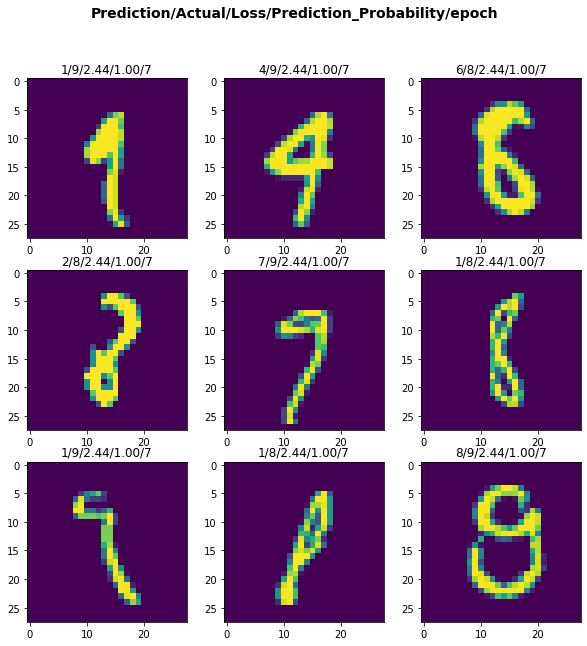

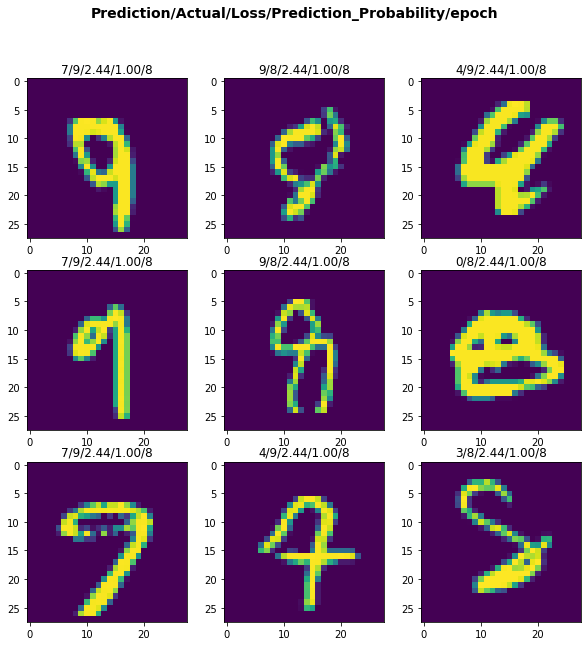

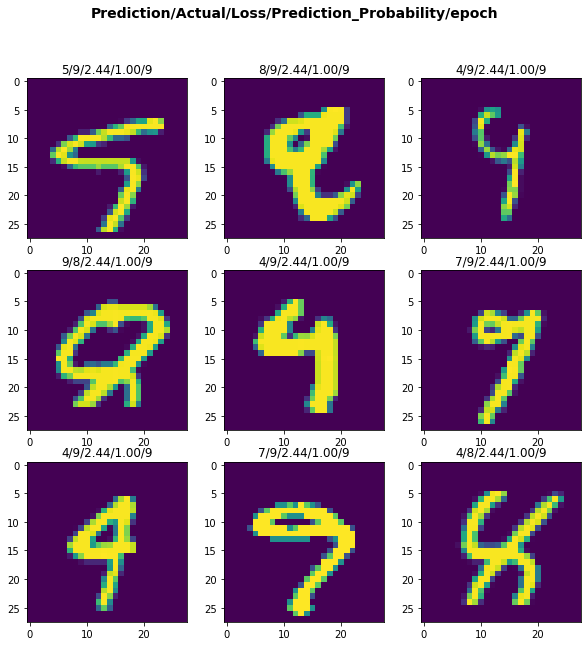

In [18]:
wandb.init(project="plot-top-losses", id="Smoothing Factor-0.2")
model = get_training_model(0.2)
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels),
                    callbacks=[PlotTopLosses(k=9, frequency=1,smoothing_factor=0.2),
                               wandb.keras.WandbCallback()])

Epoch 1/10
  65/1875 [>.............................] - ETA: 5s - loss: 2.1185 - accuracy: 0.4505

Streaming file created twice in same run: /content/wandb/run-20200518_093811-Smoothing Factor-0.3/wandb-events.jsonl
Streaming file created twice in same run: /content/wandb/run-20200518_093811-Smoothing Factor-0.3/wandb-history.jsonl


1875/1875 [==============================] - 9s 5ms/step - loss: 1.8340 - accuracy: 0.8533 - val_loss: 1.8075 - val_accuracy: 0.8908
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.7663 - accuracy: 0.9498 - val_loss: 1.7462 - val_accuracy: 0.9785
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.7443 - accuracy: 0.9816 - val_loss: 1.7458 - val_accuracy: 0.9791
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.7417 - accuracy: 0.9851 - val_loss: 1.7434 - val_accuracy: 0.9826
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.7416 - accuracy: 0.9850 - val_loss: 1.7467 - val_accuracy: 0.9773
Epoch 6/10
1875/1875 [==============================] - 8s 5ms/step - loss: 1.7406 - accuracy: 0.9864 - val_loss: 1.7406 - val_accuracy: 0.9864
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.7401 - accuracy: 0.9872 - val_loss: 1.7423 - val_accuracy: 0.9842
Epo

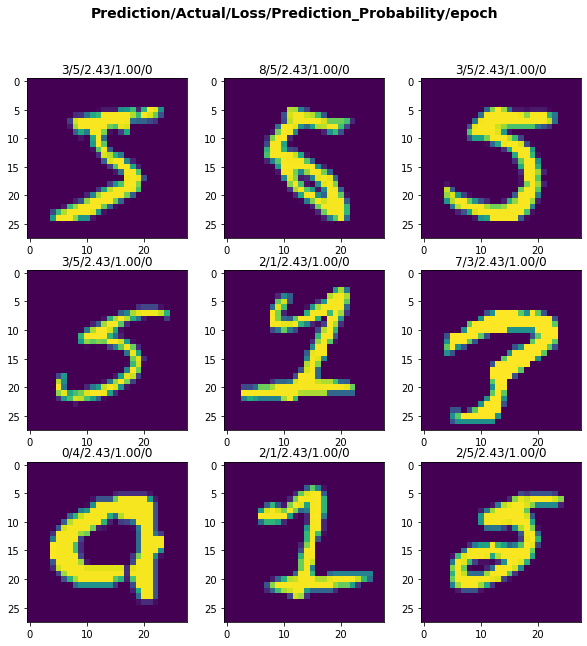

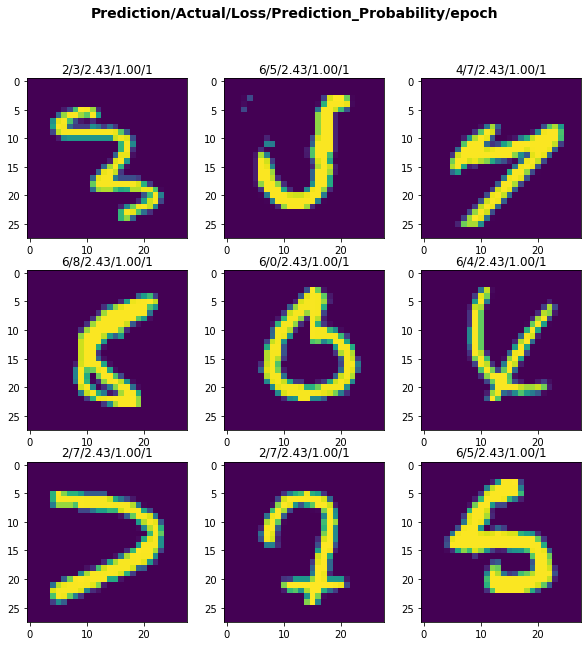

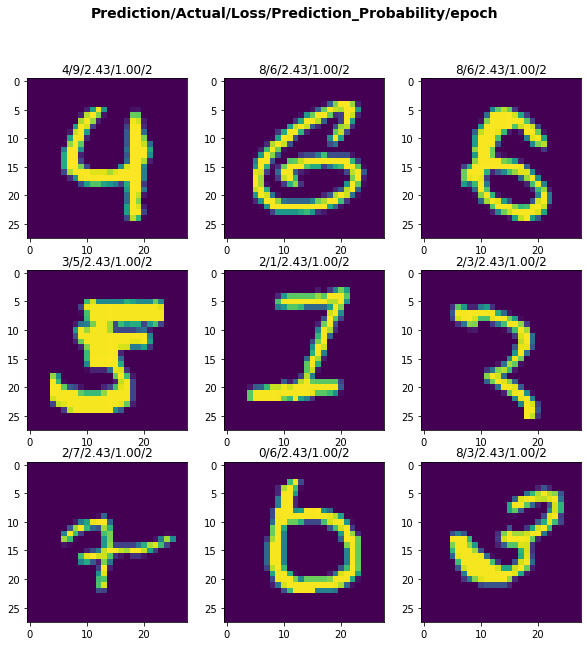

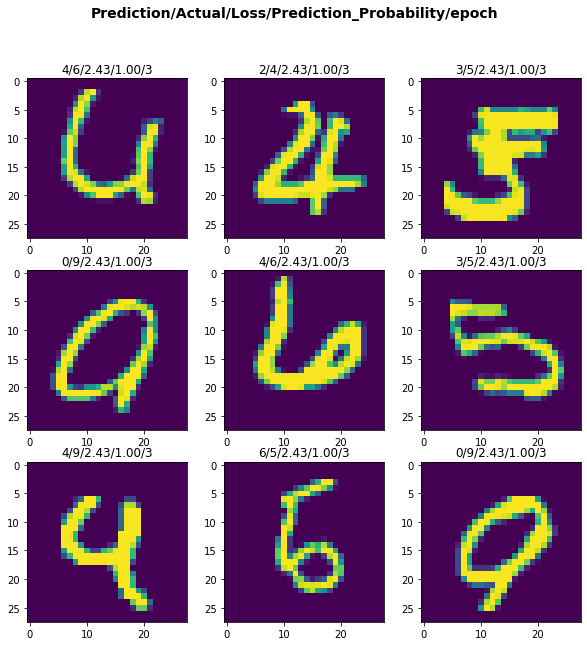

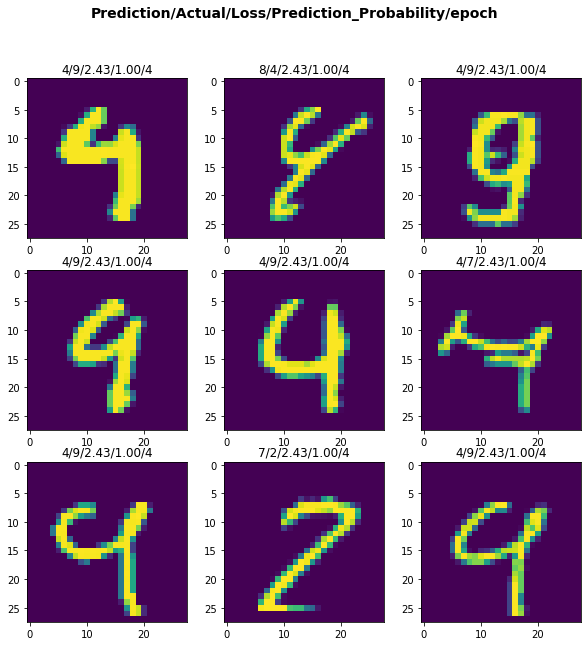

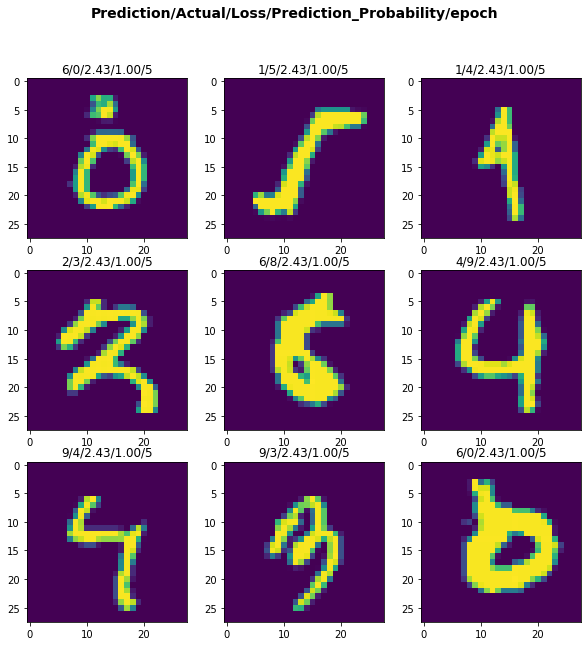

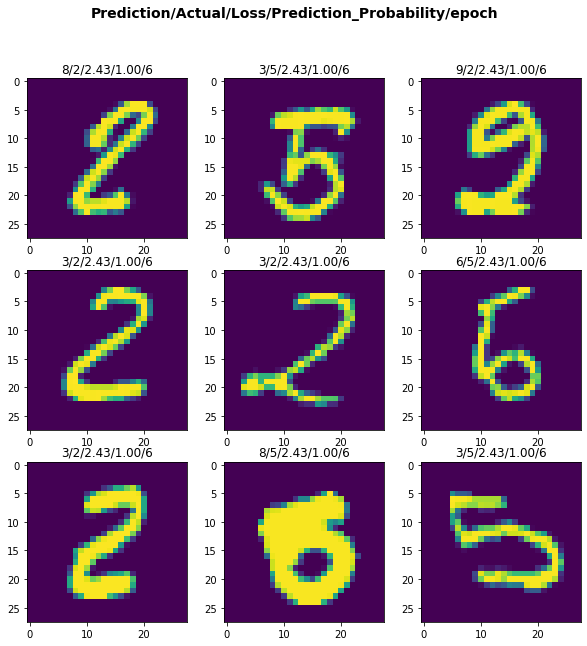

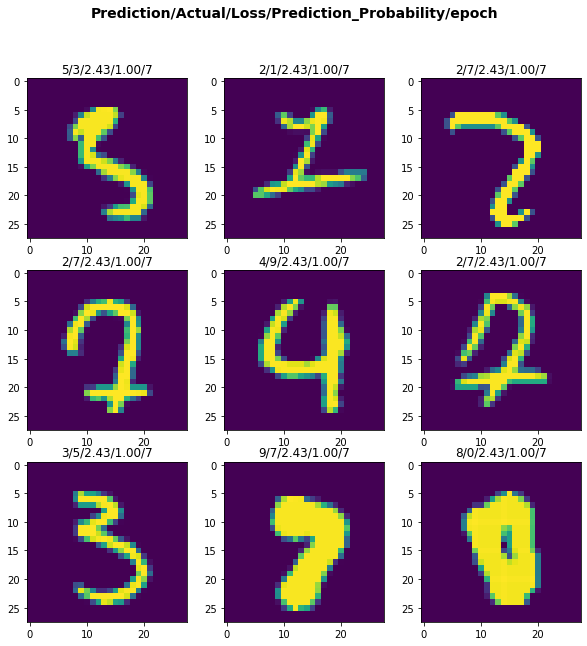

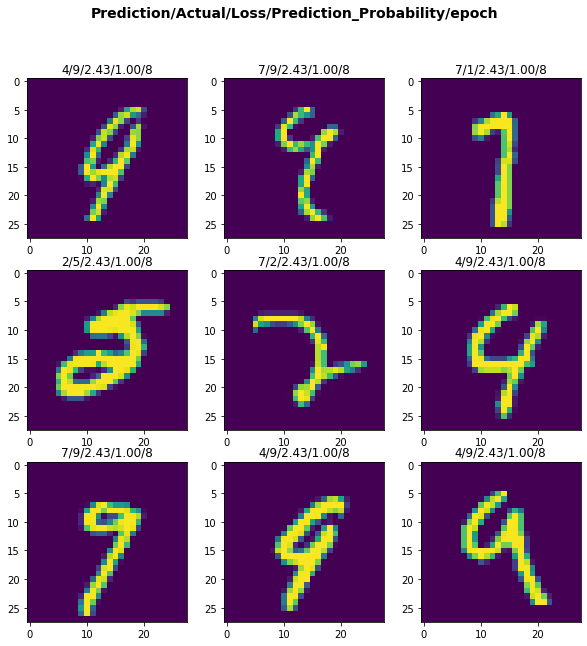

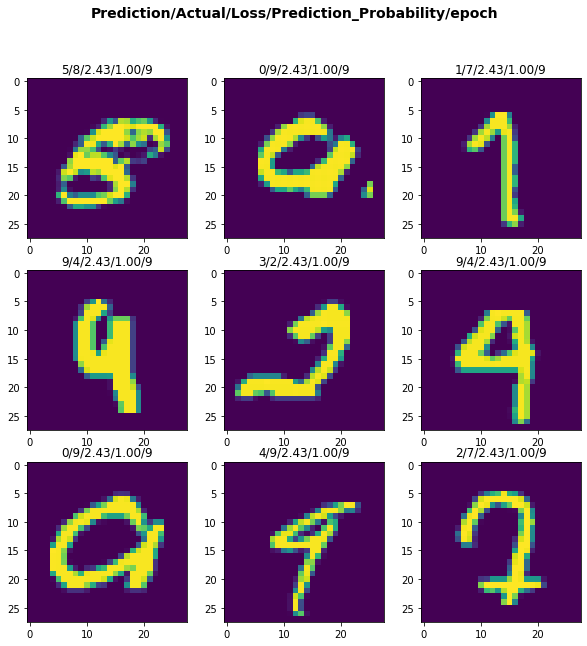

In [20]:
wandb.init(project="plot-top-losses", id="Smoothing Factor-0.3")
model = get_training_model(0.3)
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels),
                    callbacks=[PlotTopLosses(k=9, frequency=1,smoothing_factor=0.3),
                               wandb.keras.WandbCallback()])

Epoch 1/10
1875/1875 [==============================] - 8s 5ms/step - loss: 1.8600 - accuracy: 0.9369 - val_loss: 1.8342 - val_accuracy: 0.9789
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.8349 - accuracy: 0.9776 - val_loss: 1.8296 - val_accuracy: 0.9858
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.8316 - accuracy: 0.9826 - val_loss: 1.8311 - val_accuracy: 0.9833
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.8308 - accuracy: 0.9840 - val_loss: 1.8313 - val_accuracy: 0.9831
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.8300 - accuracy: 0.9852 - val_loss: 1.8316 - val_accuracy: 0.9821
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.8290 - accuracy: 0.9869 - val_loss: 1.8324 - val_accuracy: 0.9809
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.8290 - accuracy: 0.9868 - val_loss: 1.8311 - val_accuracy:

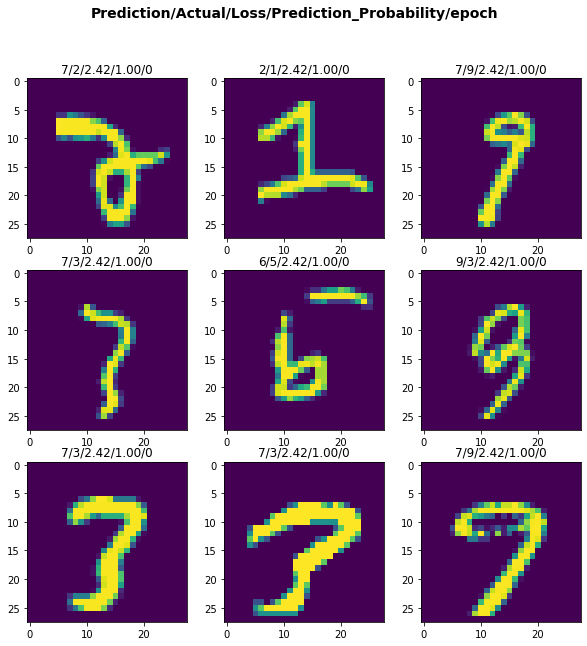

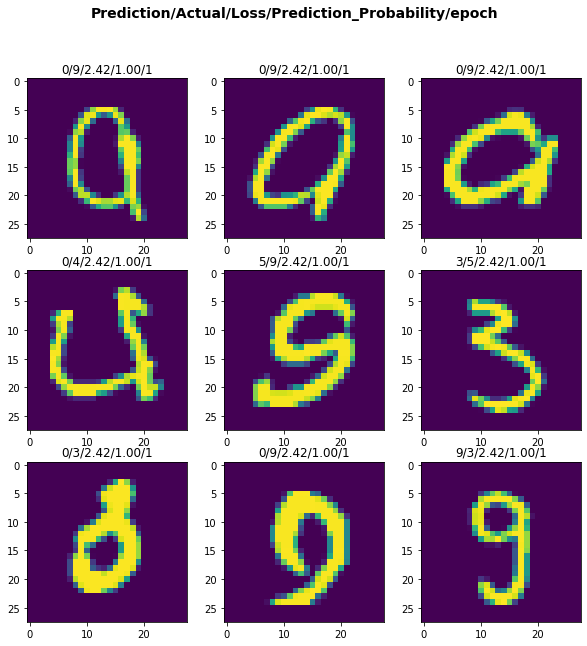

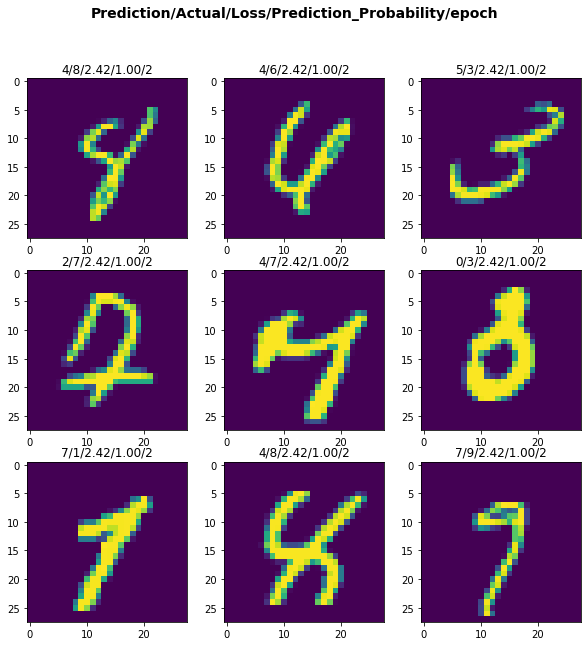

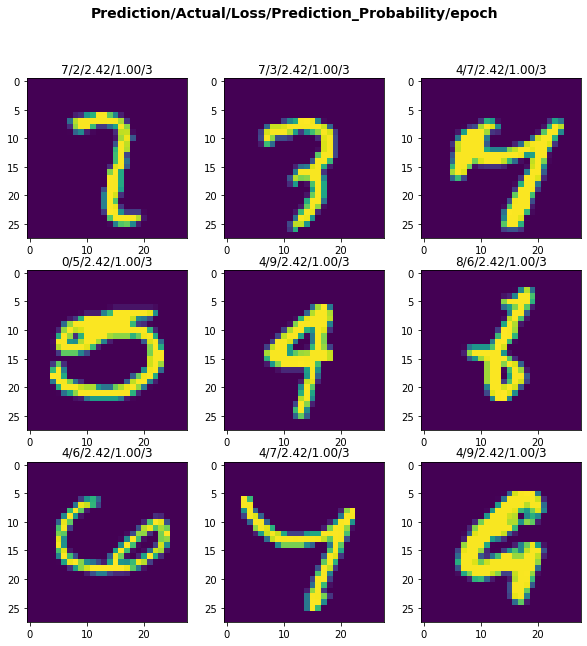

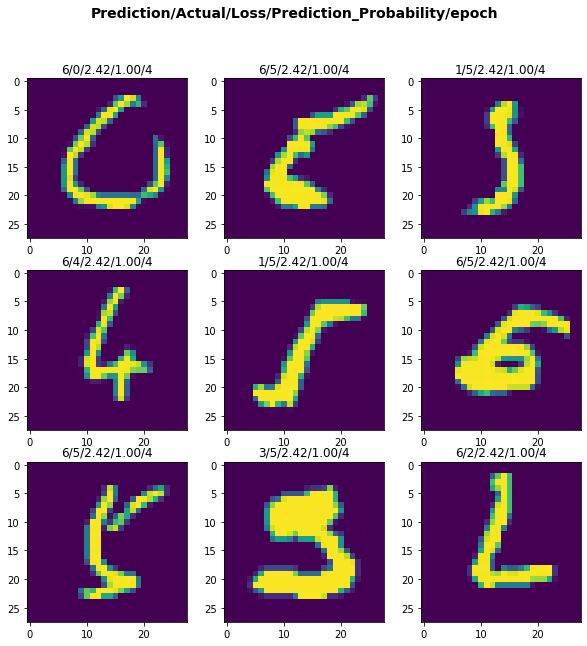

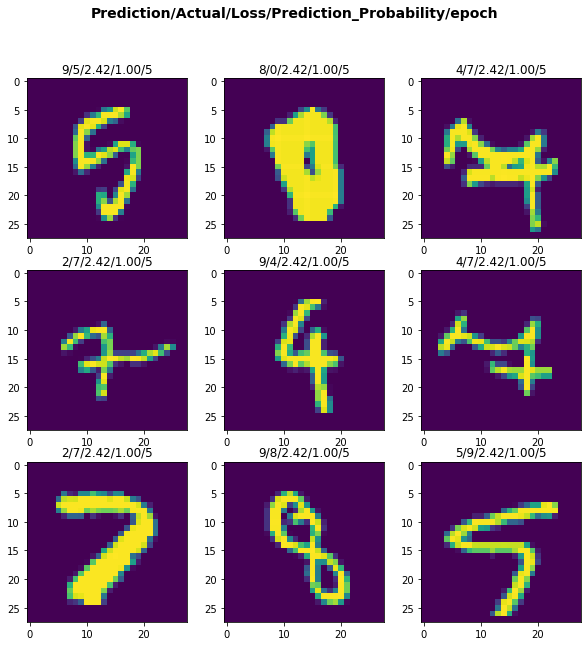

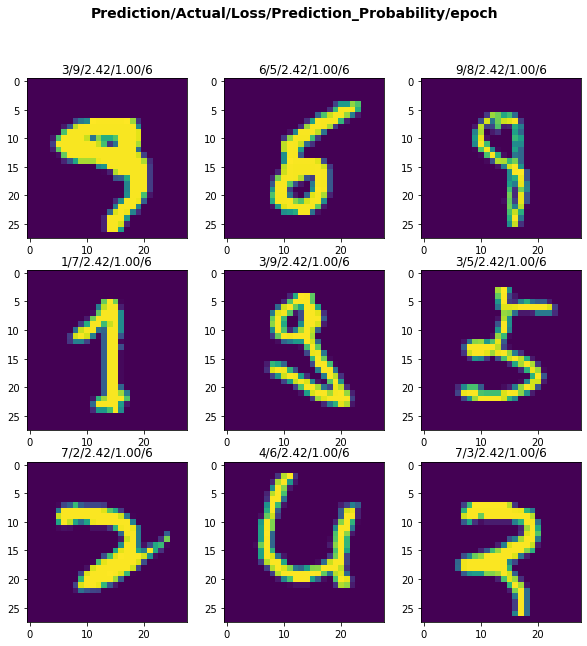

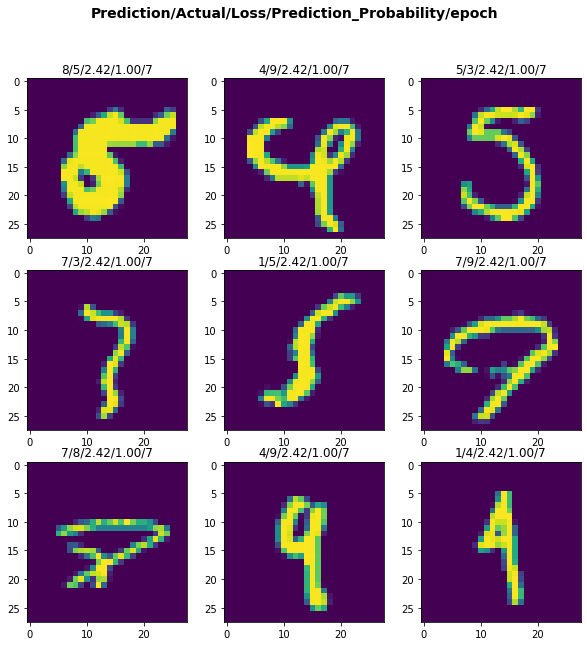

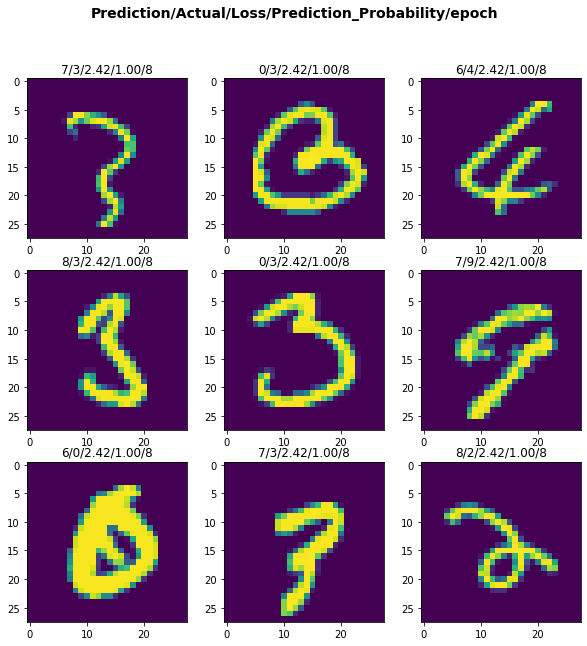

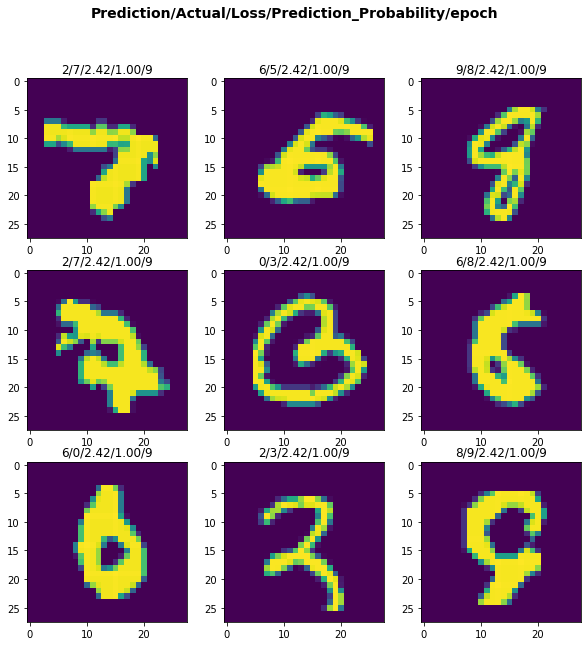

In [21]:
wandb.init(project="plot-top-losses", id="Smoothing Factor-0.4")
model = get_training_model(0.4)
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels),
                    callbacks=[PlotTopLosses(k=9, frequency=1,smoothing_factor=0.4),
                               wandb.keras.WandbCallback()])

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.9433 - accuracy: 0.9362 - val_loss: 1.9229 - val_accuracy: 0.9767
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.9224 - accuracy: 0.9775 - val_loss: 1.9270 - val_accuracy: 0.9680
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.9197 - accuracy: 0.9827 - val_loss: 1.9195 - val_accuracy: 0.9828
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.9187 - accuracy: 0.9849 - val_loss: 1.9165 - val_accuracy: 0.9895
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.9175 - accuracy: 0.9871 - val_loss: 1.9182 - val_accuracy: 0.9859
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.9174 - accuracy: 0.9874 - val_loss: 1.9194 - val_accuracy: 0.9828
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.9173 - accuracy: 0.9876 - val_loss: 1.9216 - val_accuracy:

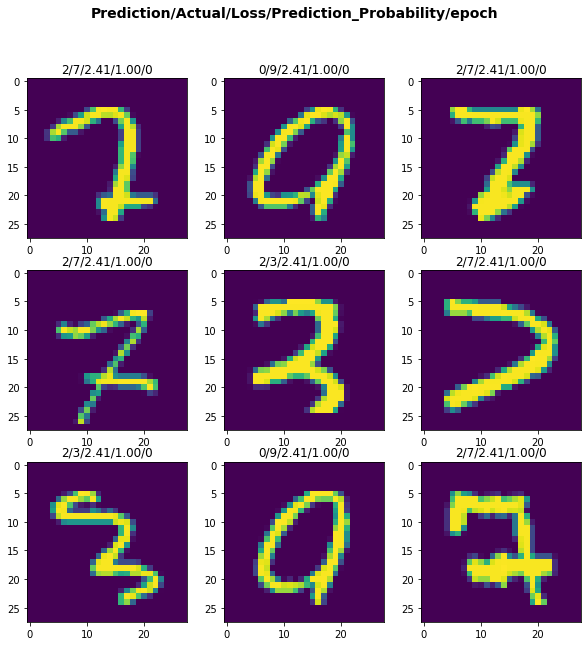

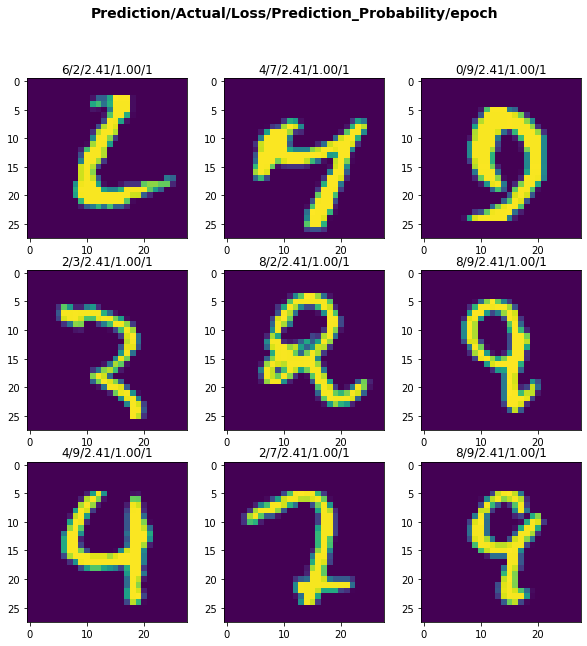

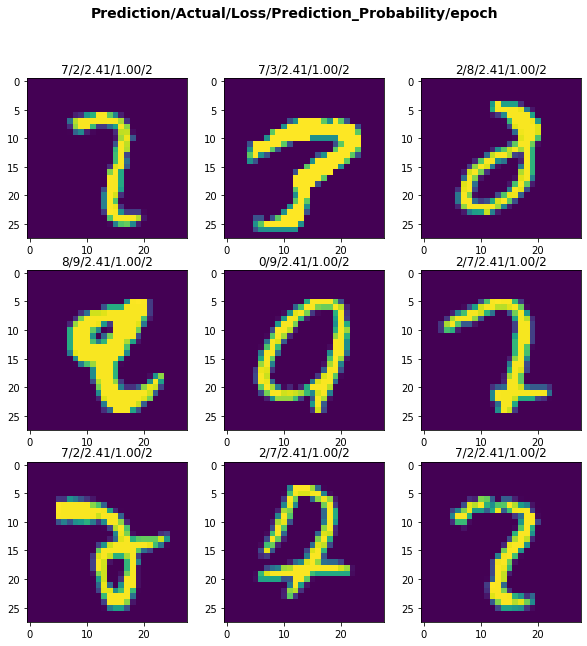

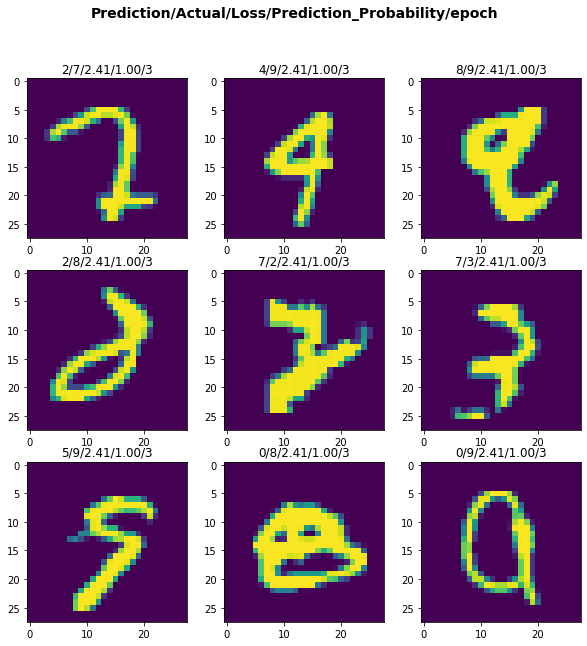

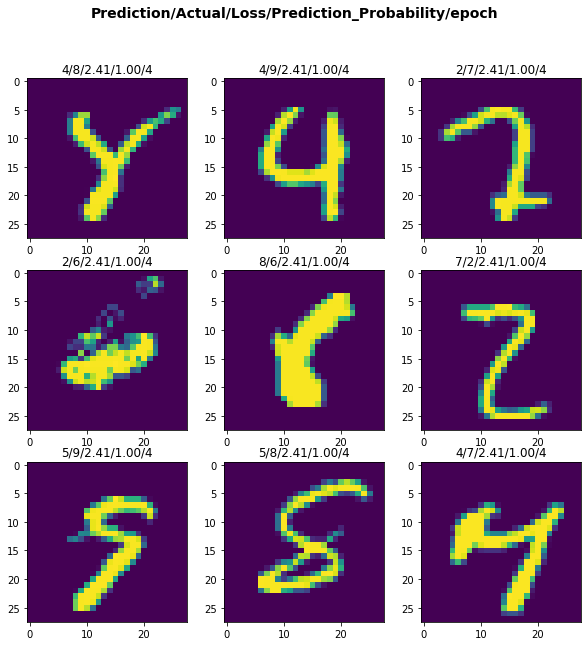

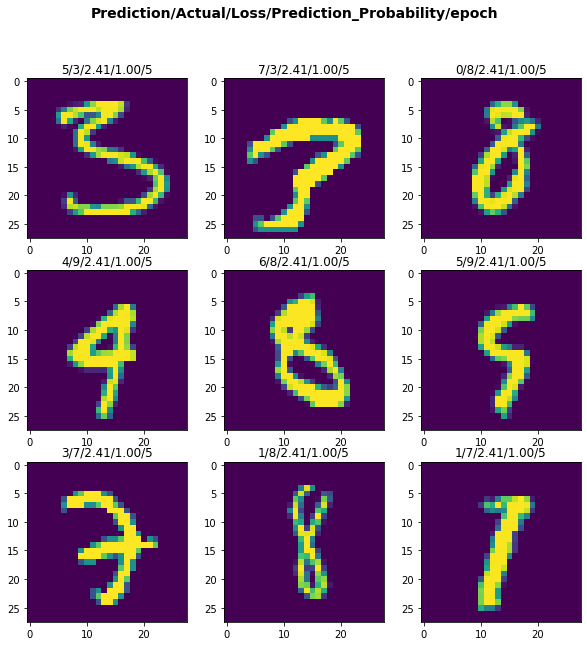

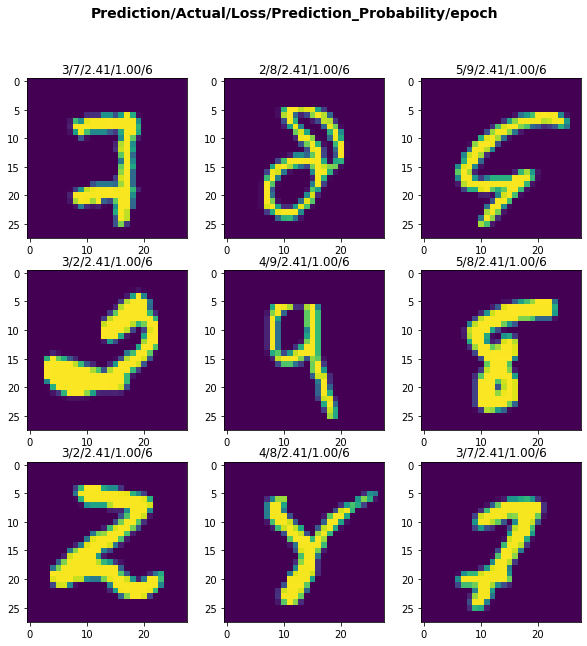

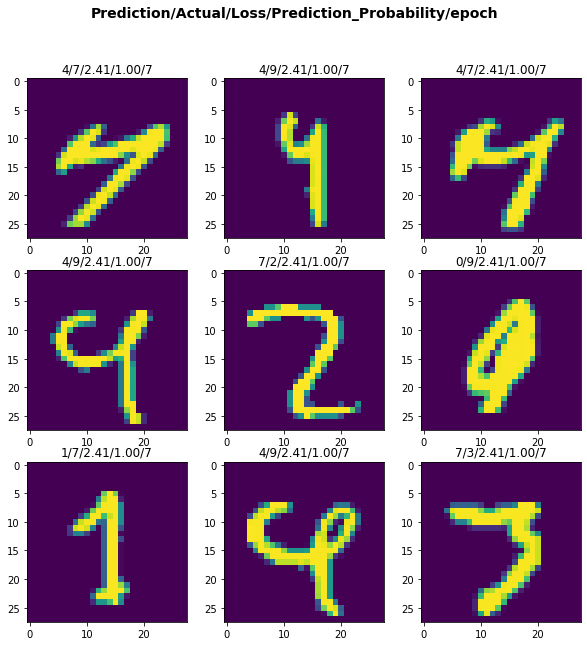

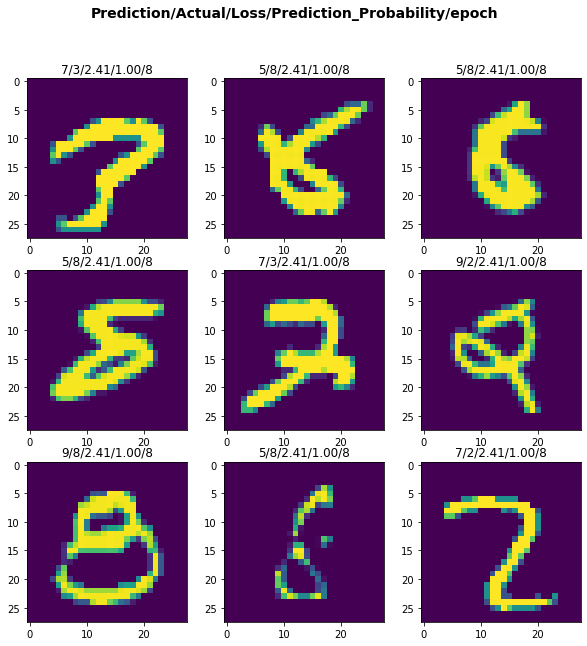

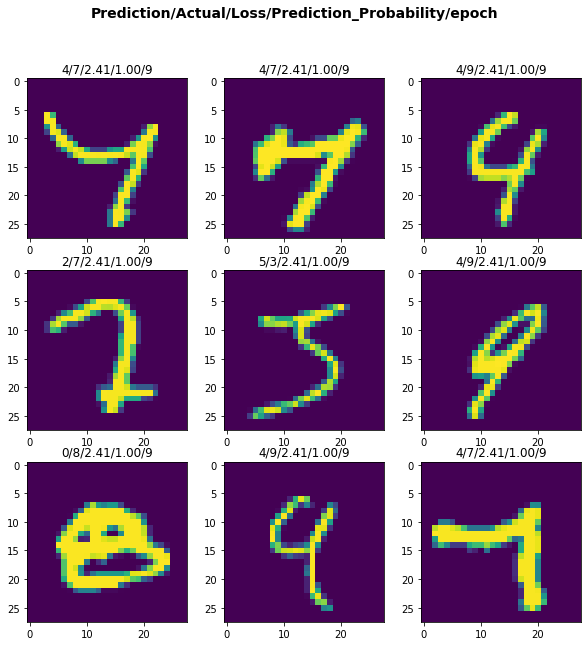

In [22]:
wandb.init(project="plot-top-losses", id="Smoothing Factor-0.5")
model = get_training_model(0.5)
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels),
                    callbacks=[PlotTopLosses(k=9, frequency=1,smoothing_factor=0.5),
                               wandb.keras.WandbCallback()])